In [1]:
import os
from PIL import Image, ImageFile
import math
import copy
import wandb
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
from torch.autograd import Variable
import torch.cuda as cuda
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from utils import *


c:\Users\Admin\.virtualenvs\AR_classification-AOelGpcL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def checkImage(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    pass

img_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.2, hue=.5),
    transforms.Resize((224,224)),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5] )
    ])

rotation = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5] )
    ])

rotation_pers = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5] )
    ])

non_augmented = transforms.Compose([
    transforms.ColorJitter(brightness=.2, hue=0,contrast=.2,saturation=.2),
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])

affine = transforms.Compose([
    transforms.ColorJitter(brightness=.2, hue=0,contrast=.2,saturation=.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5] )
    ])

def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


In [3]:
base_dir = './dataset/'
print(os.listdir(base_dir))
for base in os.listdir(base_dir):
    if base == "train":
        train_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = img_transforms, is_valid_file = checkImage)
        rotation_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = rotation, is_valid_file = checkImage)
        original_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = non_augmented, is_valid_file = checkImage)
        rotation_pers_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = rotation_pers, is_valid_file = checkImage)
        affine_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = affine, is_valid_file = checkImage)
        new_train = train_data + original_data + rotation_data + rotation_pers_data + affine_data
    elif base == "val":
        val_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = img_transforms, is_valid_file = checkImage)
        original_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = non_augmented, is_valid_file = checkImage)
        rotation_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = rotation, is_valid_file = checkImage)
        rotation_pers_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = rotation_pers, is_valid_file = checkImage)
        affine_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = affine, is_valid_file = checkImage)
        new_val = val_data + original_data + rotation_data + rotation_pers_data + affine_data
    elif base == "test":
        test_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = img_transforms, is_valid_file = checkImage)
        original_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = non_augmented, is_valid_file = checkImage)
        new_test = test_data + original_data

print(train_data)
print(val_data)
print(test_data)

['.DS_Store', 'test', 'train', 'val']
Dataset ImageFolder
    Number of datapoints: 24
    Root location: ./dataset/train
    StandardTransform
Transform: Compose(
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=None, hue=[-0.5, 0.5])
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomPerspective(p=1.0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 9
    Root location: ./dataset/val
    StandardTransform
Transform: Compose(
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=None, hue=[-0.5, 0.5])
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomPerspective(p=1.0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of

In [4]:
#By default, PyTorch’s data loaders are set to a batch_size of 1.
BATCH_SIZE = 128
train_data_loader = torch.utils.data.DataLoader(new_train, batch_size = BATCH_SIZE,shuffle=True, num_workers=2)
val_data_loader  = torch.utils.data.DataLoader(new_val, batch_size = BATCH_SIZE,shuffle=True, num_workers=2) 
test_data_loader  = torch.utils.data.DataLoader(new_test, batch_size = BATCH_SIZE,shuffle=False, num_workers=2)

num_step =math.ceil(len(train_data_loader.dataset) / BATCH_SIZE)

tensor([0, 1, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 2, 0, 1, 1, 1, 0, 2, 0, 0, 1,
        2, 1, 0, 2, 0, 0, 0, 0, 1, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1, 2,
        2, 0, 0, 2, 0, 1, 2, 0, 2, 1, 2, 2, 1, 0, 2, 1, 0, 2, 1, 1, 0, 1, 2, 1,
        2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 2, 0, 2, 2, 2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2, 1])
torch.Size([120, 3, 224, 224])


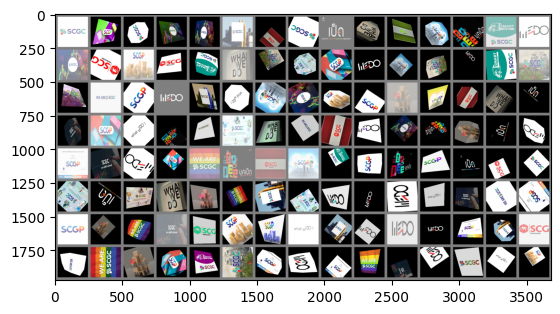

scgc scgp scgc scgc scgc scgc scgp scgc wedo wedo scgp scgp wedo scgc wedo scgc scgp scgp scgp scgc wedo scgc scgc scgp wedo scgp scgc wedo scgc scgc scgc scgc scgp wedo scgc wedo scgp scgc scgp scgp scgp scgp scgp wedo wedo scgc scgp wedo wedo scgc scgc wedo scgc scgp wedo scgc wedo scgp wedo wedo scgp scgc wedo scgp scgc wedo scgp scgp scgc scgp wedo scgp wedo scgp scgc scgc wedo scgc wedo scgp scgc scgc scgc wedo wedo wedo wedo scgc scgc scgp scgp scgp scgc scgc scgp scgp scgp wedo scgc wedo wedo wedo scgp scgc scgp scgc scgc scgp scgp scgc scgc scgp wedo scgp scgc scgc wedo scgc wedo scgp


In [5]:
classes = ('scgc','scgp','wedo')

sample = next(iter(train_data_loader))
imgs, lbls = sample
print(lbls)
print(imgs.shape)

# call function on our images
imshow(torchvision.utils.make_grid(imgs,nrow=15,padding=20))
print(' '.join('%s' % classes[lbls[j]] for j in range(len(imgs))))


In [6]:
from model import *
from torchsummary import summary
net = ResNet(ResidualBlock, [3, 4, 6, 3],num_classes=3).cuda()
summary(net, (3, 224, 224))
print(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256,

In [ ]:
 #wand setup
#"weightname":"S12_3-9_fir8-14"
#name=f"CNN_S12_3-9_fir8-14",
wandb.login()
wand = wandb.init(
      # Set the project where this run will be logged
      project="AR-classification", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"res50_AR_8", 
      # Track hyperparameters and run metadata
      # 0.0000001
      config={
      "learning_rate": 0.0001,
      "architecture": "CNN",
      "dataset": "Organization",
      "epochs": 200,
      "weightname":"res50_8",
      "num_step_per_epoch" : num_step
      }
    )

In [ ]:
config = wand.config
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=config.learning_rate, weight_decay = 0.001, momentum = 0.9)


In [ ]:
train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    loader_train = train_data_loader,
    loader_test =test_data_loader,
    vail_loader = val_data_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    device = 'cuda',
    wand = wand
)


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

In [ ]:
PATH = f"./save_weight/res50_8/0.3654_res50_8_0.3654_75.0000.pth"
# # reload
net = ResNet(ResidualBlock, [3, 4, 6, 3])
net.load_state_dict(torch.load(PATH))


In [ ]:
classes = ('scgc','scgp','wedo')
sample = next(iter(test_data_loader))
imgs, lbls = sample

# print images
imshow(torchvision.utils.make_grid(imgs))
print('GroundTruth: ', ' '.join('%s' % classes[lbls[j]] for j in  range(len(imgs))))

outputs = net(imgs)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(len(imgs))))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(labels)
        print(predicted)
        
        print(total)
        print(correct)

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))